# **Librerías**

In [1]:
import os, glob, shutil, json
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from google.colab import drive


In [2]:
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/NeuroBot/datasets"
LABELED = f"{BASE}/labeled"
DATA = f"{BASE}/data"
RUNS = "/content/drive/MyDrive/NeuroBot/models"

os.makedirs(DATA, exist_ok=True)
os.makedirs(RUNS, exist_ok=True)

print("Carpeta labeled:", LABELED)
print("Carpeta data:", DATA)


Mounted at /content/drive
Carpeta labeled: /content/drive/MyDrive/NeuroBot/datasets/labeled
Carpeta data: /content/drive/MyDrive/NeuroBot/datasets/data


# **Definir clases reales del proyecto NeuroBot**

In [3]:
CLASSES = ["asfalto", "cesped", "grava"]

# Validar conteos
conteos = {}
for c in CLASSES:
    ruta = os.path.join(LABELED, c)
    imgs = glob.glob(ruta + "/*")
    conteos[c] = len(imgs)
conteos


{'asfalto': 31, 'cesped': 30, 'grava': 30}

# **Borrar data/ y generar el split estratificado**

In [4]:
# porcentajes
train_r = 0.70
val_r   = 0.20
test_r  = 0.10

# limpiar data/
if os.path.exists(DATA):
    shutil.rmtree(DATA)

# crear carpetas
for split in ["train", "val", "test"]:
    for c in CLASSES:
        os.makedirs(os.path.join(DATA, split, c), exist_ok=True)

for c in CLASSES:
    imgs = sorted(glob.glob(os.path.join(LABELED, c, "*")))
    if len(imgs) < 20:
        print(f"  Pocas imágenes en {c}: {len(imgs)}")

    # split 70 / 30
    train_imgs, temp = train_test_split(imgs, test_size=(1-train_r), random_state=42)

    # split 30% en 20 / 10
    rel = test_r / (val_r + test_r)
    val_imgs, test_imgs = train_test_split(temp, test_size=rel, random_state=42)

    # copiar
    for p in train_imgs:
        shutil.copy(p, f"{DATA}/train/{c}/{os.path.basename(p)}")

    for p in val_imgs:
        shutil.copy(p, f"{DATA}/val/{c}/{os.path.basename(p)}")

    for p in test_imgs:
        shutil.copy(p, f"{DATA}/test/{c}/{os.path.basename(p)}")

print(" Split generado en:", DATA)


 Split generado en: /content/drive/MyDrive/NeuroBot/datasets/data


# **DataLoaders**

In [12]:
IMG_SIZE = 224
BATCH = 16

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = datasets.ImageFolder(f"{DATA}/train", transform=train_tf)
val_ds   = datasets.ImageFolder(f"{DATA}/val",   transform=test_tf)
test_ds  = datasets.ImageFolder(f"{DATA}/test",  transform=test_tf)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)

print("Clases detectadas:", class_names)


Clases detectadas: ['asfalto', 'cesped', 'grava']


# **Definir la CNN (simple y eficaz)**

In [16]:
class NeuroBotCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuroBotCNN(num_classes).to(DEVICE)
model


NeuroBotCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

# **Entrenamiento**

In [17]:
EPOCHS = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = {"train": [], "val": [], "val_acc": []}

best_val = 9999

for ep in range(EPOCHS):

    # ---- Entrenamiento ----
    model.train()
    train_loss = 0
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ---- VAL ----
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            val_loss += criterion(pred, y).item()

            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    val_acc = correct / total

    train_loss /= len(train_dl)
    val_loss /= len(val_dl)
    history["train"].append(train_loss)
    history["val"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {ep+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # guardar mejor modelo
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), f"{RUNS}/best_model.pt")




Epoch 1/15 | Train Loss: 1.7996 | Val Loss: 0.9107 | Val Acc: 0.6667
Epoch 2/15 | Train Loss: 0.8225 | Val Loss: 0.7073 | Val Acc: 0.6667
Epoch 3/15 | Train Loss: 0.5349 | Val Loss: 0.4002 | Val Acc: 0.7222
Epoch 4/15 | Train Loss: 0.4118 | Val Loss: 0.4025 | Val Acc: 0.8333
Epoch 5/15 | Train Loss: 0.3340 | Val Loss: 0.9764 | Val Acc: 0.6667
Epoch 6/15 | Train Loss: 0.3460 | Val Loss: 0.2843 | Val Acc: 0.8333
Epoch 7/15 | Train Loss: 0.2482 | Val Loss: 0.5747 | Val Acc: 0.7778
Epoch 8/15 | Train Loss: 0.2394 | Val Loss: 0.2800 | Val Acc: 0.8889
Epoch 9/15 | Train Loss: 0.2014 | Val Loss: 0.3705 | Val Acc: 0.9444
Epoch 10/15 | Train Loss: 0.1823 | Val Loss: 0.1950 | Val Acc: 0.8333
Epoch 11/15 | Train Loss: 0.1923 | Val Loss: 0.2198 | Val Acc: 0.8889
Epoch 12/15 | Train Loss: 0.1564 | Val Loss: 0.4809 | Val Acc: 0.8333
Epoch 13/15 | Train Loss: 0.2054 | Val Loss: 0.3568 | Val Acc: 0.9444
Epoch 14/15 | Train Loss: 0.1498 | Val Loss: 0.1672 | Val Acc: 0.8333
Epoch 15/15 | Train Loss: 0.1

# **Gráfica de pérdidas**

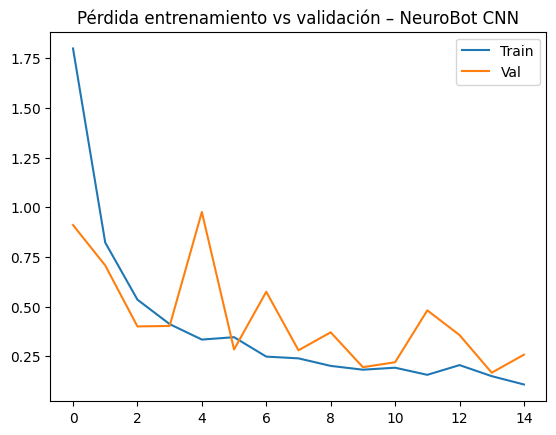

In [19]:
plt.plot(history["train"], label="Train")
plt.plot(history["val"], label="Val")
plt.legend()
plt.title("Pérdida entrenamiento vs validación – NeuroBot CNN")
plt.show()


# **Guardar config + clases**

In [21]:
config = {
    "img_size": IMG_SIZE,
    "batch": BATCH,
    "num_classes": num_classes,
    "classes": class_names,
    "saved": datetime.now().isoformat(),
    "arch": "NeuroBotCNN"
}

with open(f"{RUNS}/config.json", "w") as f:
    json.dump(config, f, indent=2)

with open(f"{RUNS}/classes.json", "w") as f:
    json.dump(class_names, f, indent=2)

print(" Config guardada")
print("Modelo guardado en:", f"{RUNS}/best_model.pt")


 Config guardada
Modelo guardado en: /content/drive/MyDrive/NeuroBot/models/best_model.pt
